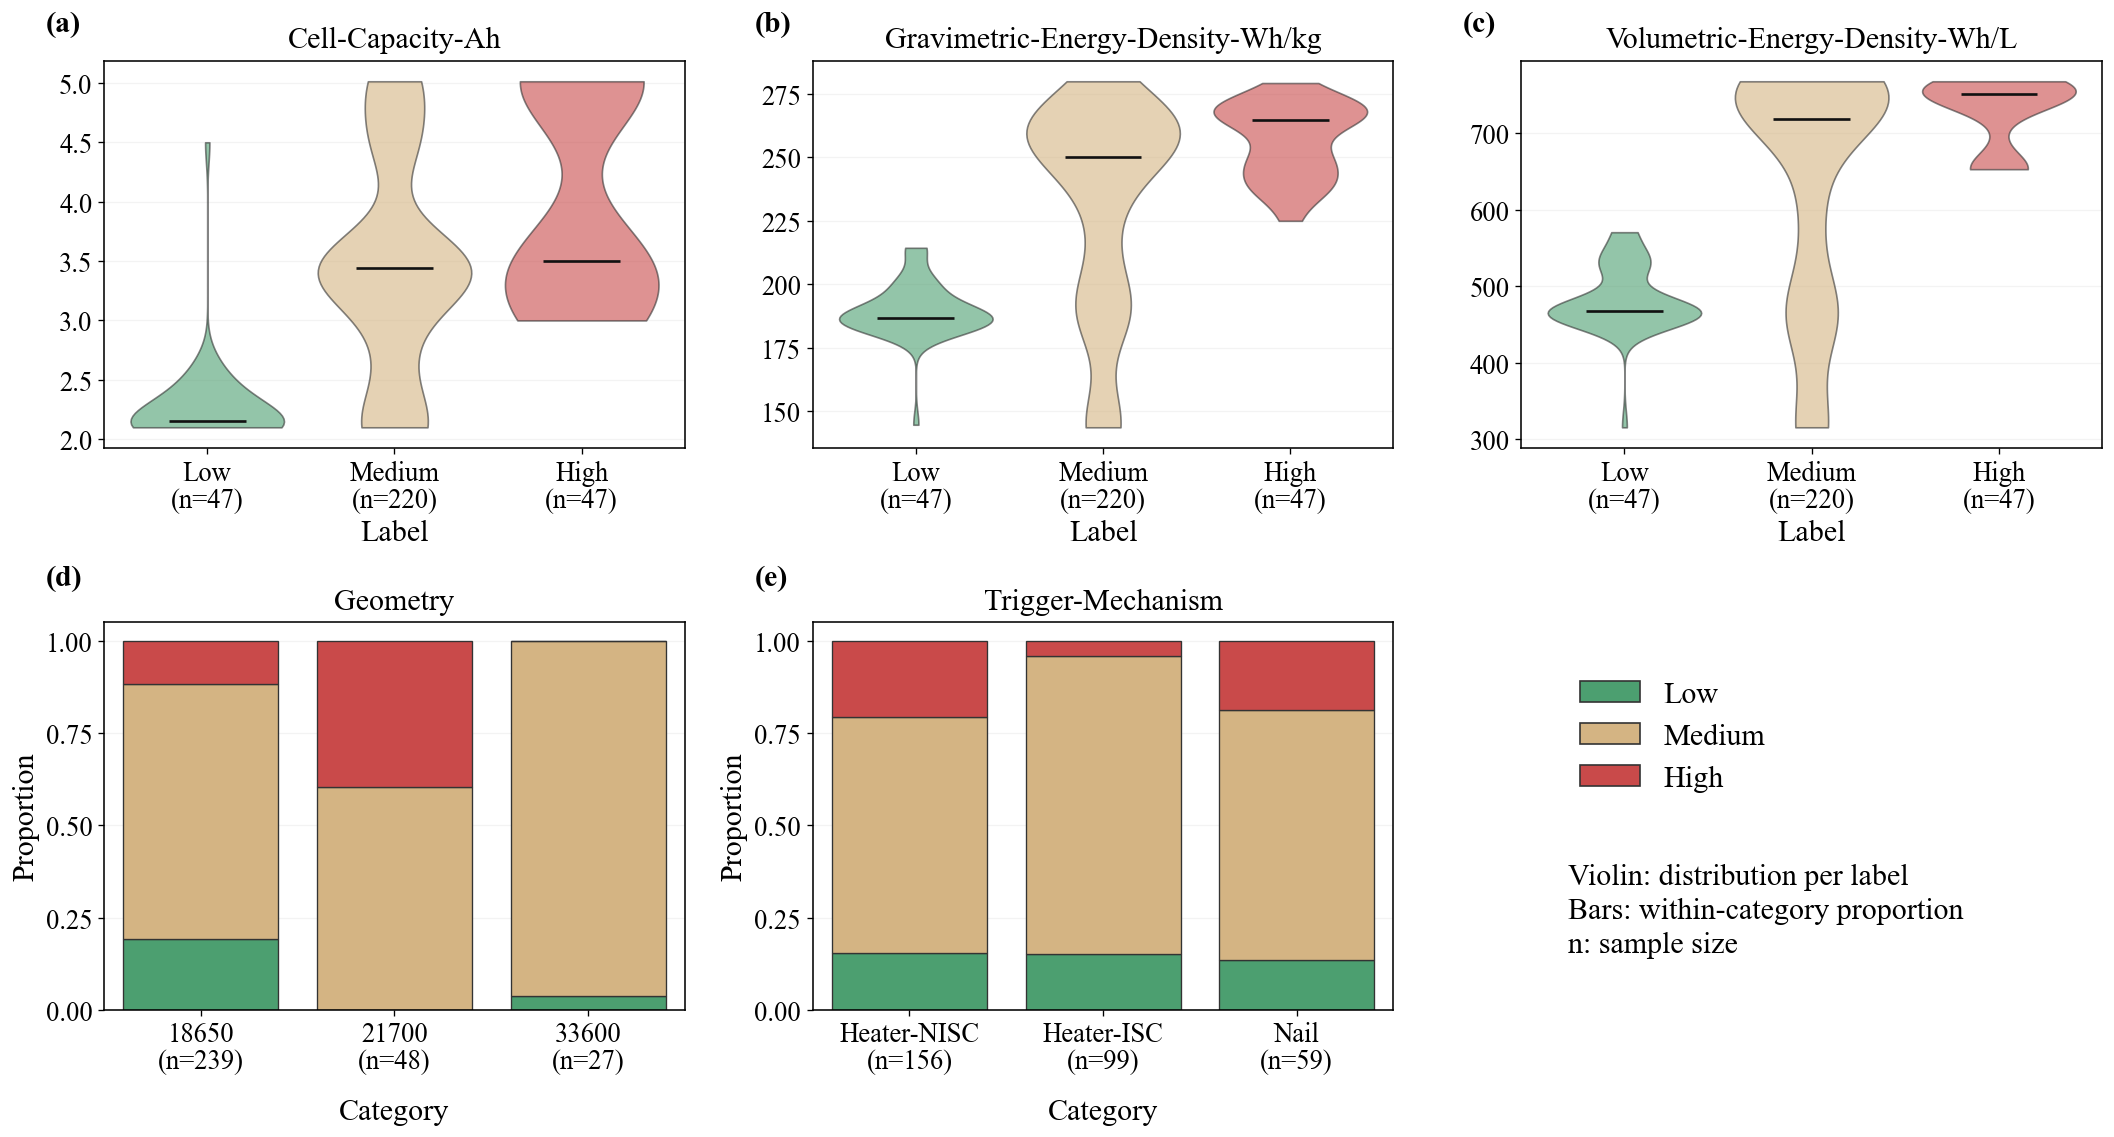

Saved:
 - ./plot\paper_feature_distributions_compact.png
 - ./plot\paper_feature_distributions_compact.pdf


In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# Configuration 
# =========================
CLASS_ORDER = ["Low", "Medium", "High"]
CLASS_COLORS = {
    "Low": "#4C9F70",      # muted green
    "Medium": "#D4B483",   # desaturated sand / khaki
    "High": "#C94A4A",     # muted red
}

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 18,
    "axes.linewidth": 1.0,
})

DATA_PATH = "data/dataframe_processed.xlsx"
OUT_DIR = "./plot"
os.makedirs(OUT_DIR, exist_ok=True)

FEATURE_ORDER = [
    "Cell-Capacity-Ah",
    "Gravimetric-Energy-Density-Wh/kg",
    "Volumetric-Energy-Density-Wh/L",
    "Geometry",
    "Trigger-Mechanism",
]

NUM_FEATURES = {
    "Cell-Capacity-Ah",
    "Gravimetric-Energy-Density-Wh/kg",
    "Volumetric-Energy-Density-Wh/L",
}

TRIGGER_LABEL_MAP = {
    "Heater (Non-ISC)": "Heater-NISC",
    "Heater (ISC)": "Heater-ISC",
    "Nail": "Nail",
}

# =========================
# Load data
# =========================
df = pd.read_excel(DATA_PATH)
y_col = df.columns[-1]
df[y_col] = df[y_col].astype(str)

present_classes = [c for c in CLASS_ORDER if c in set(df[y_col].dropna())]
if not present_classes:
    raise ValueError(f"No valid labels found in '{y_col}'. Expected one of {CLASS_ORDER}.")

missing = [c for c in FEATURE_ORDER if c not in df.columns]
if missing:
    raise ValueError(f"Missing feature columns in the dataset: {missing}")

for c in NUM_FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# =========================
# Helpers
# =========================
def style_axes(ax, grid_alpha=0.14):
    ax.grid(True, axis="y", alpha=grid_alpha, linewidth=0.8)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_alpha(0.95)

def add_panel_label(ax, label_text, row=0):
    y = 1.06 if row == 0 else 1.08
    ax.text(
        -0.10, y, label_text,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="bold",
        va="bottom",
        ha="left",
        bbox=dict(facecolor="white", edgecolor="none", pad=0.6, alpha=0.95)
    )

def n_per_label(data, feature, y_col, labels):
    return {lab: int(data.loc[data[y_col] == lab, feature].dropna().shape[0]) for lab in labels}

def build_topn_other(series, top_n=10):
    vc = series.value_counts(dropna=False)
    top = list(vc.head(top_n).index)
    return series.where(series.isin(top), other="Other")

# =========================
# Plotters
# =========================
def plot_violin(ax, data, feature, y_col, labels):
    groups, used = [], []
    for lab in labels:
        vals = data.loc[data[y_col] == lab, feature].dropna().values
        if len(vals) > 0:
            groups.append(vals)
            used.append(lab)

    if not groups:
        ax.text(0.5, 0.5, f"No data: {feature}", ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        return

    pos = np.arange(1, len(groups) + 1)
    v = ax.violinplot(
        groups,
        positions=pos,
        widths=0.82,
        showmeans=False,
        showmedians=True,
        showextrema=False
    )

    for body, lab in zip(v["bodies"], used):
        body.set_facecolor(CLASS_COLORS.get(lab, "#888888"))
        body.set_edgecolor("#333333")
        body.set_alpha(0.60)
        body.set_linewidth(1.0)

    v["cmedians"].set_color("#111111")
    v["cmedians"].set_linewidth(1.6)

    ax.set_title(feature, pad=8)

    counts = n_per_label(data, feature, y_col, used)
    tick_labels = [f"{lab}\n(n={counts[lab]})" for lab in used]
    ax.set_xticks(pos)
    ax.set_xticklabels(tick_labels, ha="center", linespacing=1.05)

    ax.set_xlabel("Label", labelpad=4)
    ax.margins(y=0.06)
    style_axes(ax)

def plot_categorical_stacked_xtick_n(ax, data, feature, y_col, labels, top_n=10, rename_map=None):
    s = data[feature].astype("string").fillna("Missing")
    if rename_map is not None:
        s = s.replace(rename_map)

    s2 = build_topn_other(s, top_n=top_n)
    cat_counts = s2.value_counts(dropna=False)

    ct = pd.crosstab(s2, data[y_col].astype(str))
    for lab in labels:
        if lab not in ct.columns:
            ct[lab] = 0
    ct = ct[labels]

    totals = ct.sum(axis=1)
    ct = ct.loc[totals.sort_values(ascending=False).index]

    denom = ct.sum(axis=1).replace(0, np.nan)
    plot_df = ct.div(denom, axis=0).fillna(0.0)

    cats = list(plot_df.index)
    x = np.arange(len(cats))
    bottom = np.zeros(len(cats))

    for lab in labels:
        ax.bar(
            x,
            plot_df[lab].values,
            bottom=bottom,
            color=CLASS_COLORS.get(lab, "#888888"),
            edgecolor="#333333",
            linewidth=0.8
        )
        bottom += plot_df[lab].values

    ax.set_title(feature, pad=8)

    tick_labels = [f"{c}\n(n={int(cat_counts.get(c, 0))})" for c in cats]
    ax.set_xticks(x)
    ax.set_xticklabels(tick_labels, ha="center", linespacing=1.05)

    ax.set_xlim(-0.5, len(cats) - 0.5)
    ax.set_ylim(0, 1.05)
    ax.set_yticks([0, 0.25, 0.50, 0.75, 1.00])

    ax.set_ylabel("Proportion")
    ax.set_xlabel("Category", labelpad=14)  # extra spacing to avoid collision with the 2-line ticks
    style_axes(ax)

def draw_legend_panel(ax, classes, colors, y_col):
    ax.axis("off")

    handles = [Patch(facecolor=colors[c], edgecolor="#333333", label=c) for c in classes]

    # Use the empty space better: put legend on top-left, and a spaced text block below.
    ax.legend(
        handles=handles,
        loc="upper left",
        bbox_to_anchor=(0.08, 0.88),
        frameon=False,
        ncol=1,
        borderaxespad=0.0
    )

    text = (
        f"Violin: distribution per label\n"
        "Bars: within-category proportion\n"
        "n: sample size"
    )
    ax.text(
        0.08, 0.38,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=18,
        linespacing=1.35
    )

# =========================
# Figure layout
# =========================
fig, axes = plt.subplots(2, 3, figsize=(18, 9.2))
axes = axes.reshape(-1)

panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]

for i, feat in enumerate(FEATURE_ORDER):
    ax = axes[i]

    if feat in NUM_FEATURES:
        plot_violin(ax, df, feat, y_col, present_classes)
    else:
        rename_map = TRIGGER_LABEL_MAP if feat == "Trigger-Mechanism" else None
        plot_categorical_stacked_xtick_n(ax, df, feat, y_col, present_classes, top_n=10, rename_map=rename_map)

    row = 0 if i < 3 else 1
    add_panel_label(ax, panel_labels[i], row=row)

# Legend panel in the bottom-right slot
draw_legend_panel(axes[5], present_classes, CLASS_COLORS, y_col)

# Make the second row (d,e,legend) sit a bit higher by reducing vertical spacing.
# Also give more top margin to avoid crowded titles.
fig.subplots_adjust(
    left=0.06, right=0.985,
    top=0.96, bottom=0.10,
    wspace=0.22, hspace=0.45  # smaller hspace lifts row 2 upward
)

plt.show()

# =========================
# Save outputs
# =========================
out_png = os.path.join(OUT_DIR, "paper_feature_distributions_compact.png")
out_pdf = os.path.join(OUT_DIR, "paper_feature_distributions_compact.pdf")
fig.savefig(out_png, bbox_inches="tight", dpi=600)
fig.savefig(out_pdf, bbox_inches="tight")

print("Saved:")
print(" -", out_png)
print(" -", out_pdf)